In [4]:
import tensorflow as tf

# Set memory growth for GPUs
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

print("Memory growth enabled for GPU:", physical_devices)


Memory growth enabled for GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
from tensorflow.keras.mixed_precision import set_global_policy

# Set mixed precision policy
set_global_policy('mixed_float16')

print("Mixed precision enabled.")


Mixed precision enabled.


In [6]:
import os 
file_size = os.path.getsize("data_splits_128.pkl")
print(f"File size: {file_size} bytes")

File size: 2048000447 bytes


In [7]:
import pickle

with open('data_splits.pkl', 'rb') as f:
    X_train, X_val, X_test, y_train, y_val, y_test = pickle.load(f)

print("Data splits loaded from pickle!")

Data splits loaded from pickle!


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout, Add
from tensorflow.keras.models import Model

In [9]:
def build_unet(input_shape=(128, 128, 3), num_classes=4):
    inputs = Input(input_shape)
    
   # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.3)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    residual_1 = Conv2D(64, (1, 1), padding='same')(inputs)  # Residual connection
    c1 = Add()([c1, residual_1])
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.3)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    residual_2 = Conv2D(128, (1, 1), padding='same')(p1)
    c2 = Add()([c2, residual_2])
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.3)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    residual_3 = Conv2D(256, (1, 1), padding='same')(p2)
    c3 = Add()([c3, residual_3])
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.3)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)

    # Decoder
    u1 = UpSampling2D((2, 2))(c4)
    u1 = concatenate([u1, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    c5 = BatchNormalization()(c5)

    u2 = UpSampling2D((2, 2))(c5)
    u2 = concatenate([u2, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c6 = BatchNormalization()(c6)

    u3 = UpSampling2D((2, 2))(c6)
    u3 = concatenate([u3, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c7 = BatchNormalization()(c7)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c7)

    model = Model(inputs, outputs)
    return model

# Build and summarize the baseline U-Net model
baseline_unet_model = build_unet(input_shape=(128, 128, 3), num_classes=4)
baseline_unet_model.summary()
    

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [10]:
import numpy as np 

input_shape = (128,128,3)

num_classes = len(np.unique(y_train))

baseline_unet_model = build_unet(input_shape = input_shape, num_classes = num_classes)


In [11]:
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)


(3500, 128, 128, 3) (1005, 128, 128, 3)
(3500, 128, 128) (1005, 128, 128)


In [12]:
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)

X_train dtype: float64
y_train dtype: uint8


In [13]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 378873336000110247
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3457200128
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6917618898598670241
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:2d:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [14]:
from tensorflow.keras.backend import clear_session
import gc

clear_session()
gc.collect()


3789

In [15]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True 
)

baseline_unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                    loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])


y_train = y_train.astype('int32')
y_val = y_val.astype('int32')

history = baseline_unet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,  
    batch_size=3,
    callbacks=[early_stopping]  
    )

Epoch 1/10
1167/1167 [==============================] - 48s 33ms/step - loss: inf - accuracy: 0.9140 - val_loss: 0.2567 - val_accuracy: 0.9324
Epoch 2/10
1167/1167 [==============================] - 36s 31ms/step - loss: 0.1412 - accuracy: 0.9512 - val_loss: 0.1748 - val_accuracy: 0.9451
Epoch 3/10
1167/1167 [==============================] - 36s 31ms/step - loss: 0.1139 - accuracy: 0.9602 - val_loss: 0.1153 - val_accuracy: 0.9601
Epoch 4/10
1167/1167 [==============================] - 36s 31ms/step - loss: 0.0986 - accuracy: 0.9652 - val_loss: 0.1014 - val_accuracy: 0.9648
Epoch 5/10
1167/1167 [==============================] - 36s 31ms/step - loss: 0.0899 - accuracy: 0.9681 - val_loss: 0.0868 - val_accuracy: 0.9690
Epoch 6/10
1167/1167 [==============================] - 36s 31ms/step - loss: 0.0807 - accuracy: 0.9711 - val_loss: 0.0849 - val_accuracy: 0.9698
Epoch 7/10
1167/1167 [==============================] - 36s 31ms/step - loss: 0.0742 - accuracy: 0.9733 - val_loss: 0.0740 - va

In [17]:
y_pred = baseline_unet_model.predict(X_val)  # Predict the outputs
y_pred_argmax = np.argmax(y_pred, axis=-1)  # Convert from one-hot encoding to class index


32/32 [==============================] - 3s 58ms/step


In [18]:
y_val = y_val.astype('int32')  # Ensure y_val is integer
y_pred_argmax = y_pred_argmax.astype('int32')  # Ensure predictions are integer


In [19]:
print(f"y_val shape: {y_val.shape}, dtype: {y_val.dtype}")
print(f"y_pred_argmax shape: {y_pred_argmax.shape}, dtype: {y_pred_argmax.dtype}")


y_val shape: (1005, 128, 128), dtype: int32
y_pred_argmax shape: (1005, 128, 128), dtype: int32


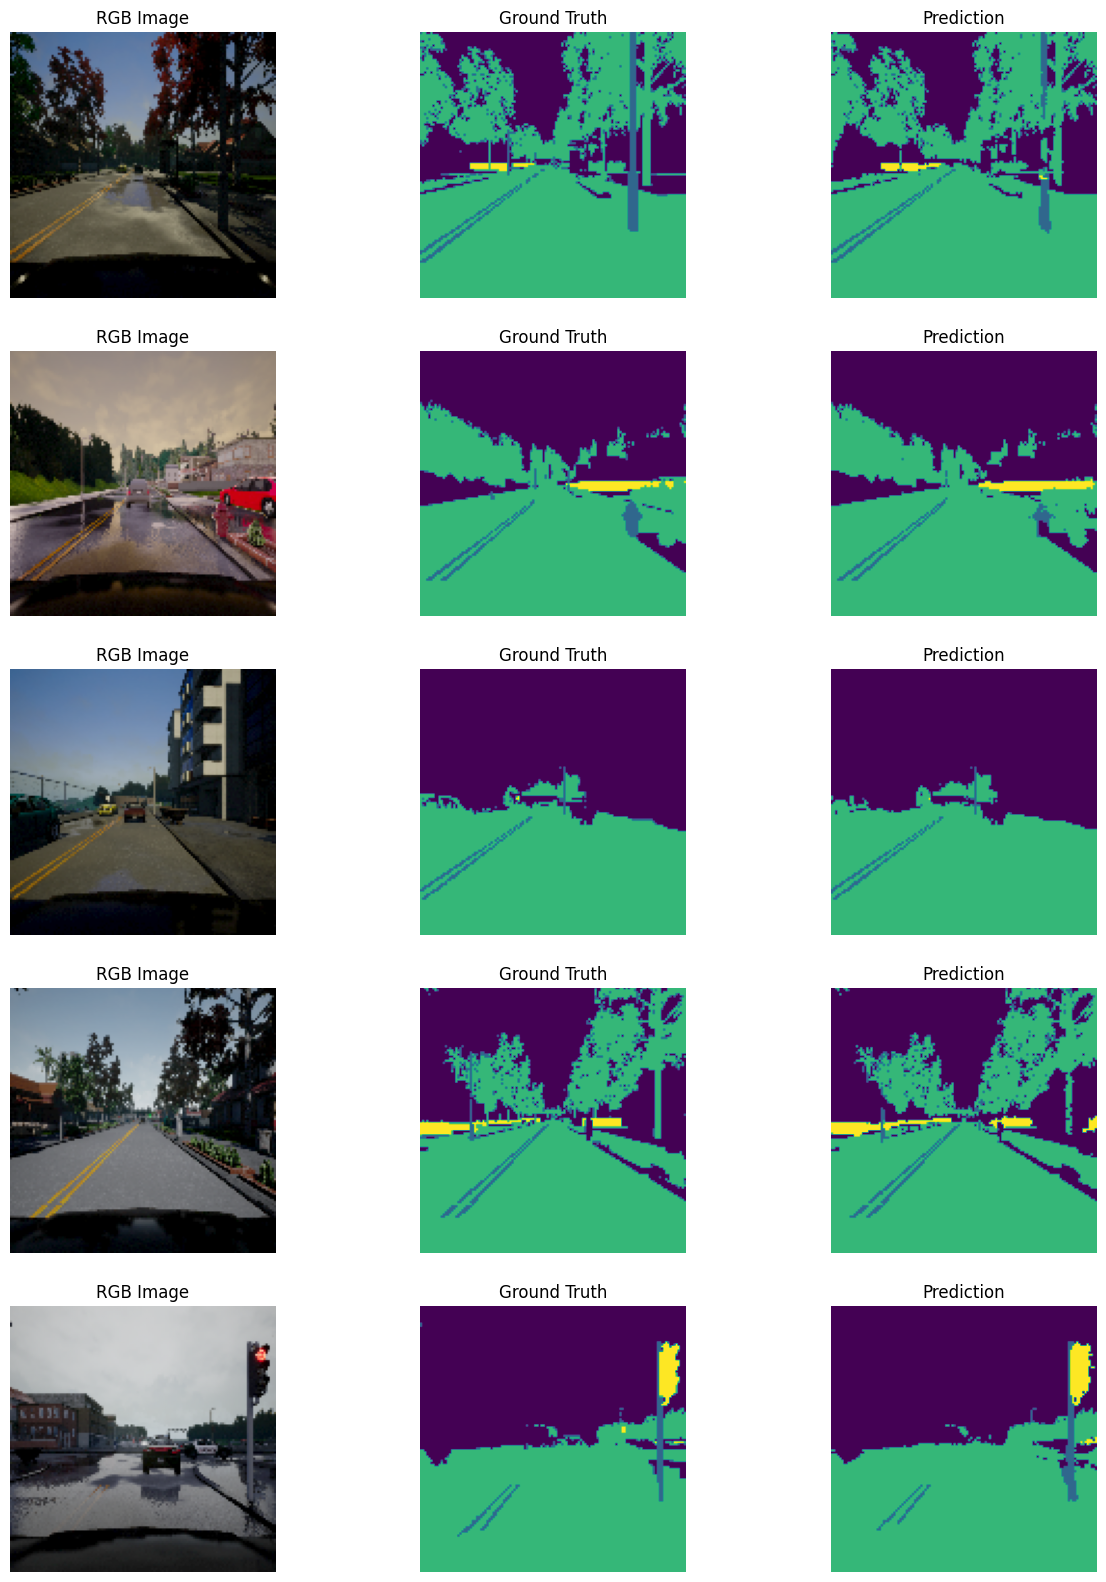

In [21]:
import matplotlib.pyplot as plt

def visualize_predictions(images, ground_truth, predictions, num_samples=5):
    plt.figure(figsize=(15, num_samples * 4))
    for i in range(num_samples):
        plt.subplot(num_samples, 3, 3 * i + 1)
        plt.imshow(images[i])
        plt.title('RGB Image')
        plt.axis('off')

        plt.subplot(num_samples, 3, 3 * i + 2)
        plt.imshow(ground_truth[i], cmap='viridis')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(num_samples, 3, 3 * i + 3)
        plt.imshow(predictions[i], cmap='viridis')
        plt.title('Prediction')
        plt.axis('off')
    plt.show()

# Visualize a few predictions
visualize_predictions(X_val[:5], y_val[:5], y_pred_argmax[:5])


In [22]:
baseline_unet_model.save("baseline_unet_model.h5")

In [24]:
from tensorflow.keras.metrics import MeanIoU

# Calculate IoU
num_classes = 4  # Adjust based on your dataset
iou_metric = MeanIoU(num_classes=num_classes)
iou_metric.update_state(y_test, baseline_unet_model.predict(X_test).argmax(axis=-1))

print(f"Mean IoU for U-Net Model: {iou_metric.result().numpy()}")

16/16 [==============================] - 1s 84ms/step
Mean IoU for U-Net Model: 0.8143206238746643


In [25]:
# Pixel Accuracy
y_pred = baseline_unet_model.predict(X_test).argmax(axis=-1)
pixel_accuracy = np.mean(y_pred == y_test)

print(f"Pixel Accuracy for U-Net Model: {pixel_accuracy}")

16/16 [==============================] - 1s 50ms/step
Pixel Accuracy for U-Net Model: 0.976904420178346


In [26]:
def build_dilated_unet(input_shape=(128, 128, 3), num_classes=4):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.3)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    residual_1 = Conv2D(64, (1, 1), padding='same')(inputs)  # Residual connection
    c1 = Add()([c1, residual_1])
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.3)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    residual_2 = Conv2D(128, (1, 1), padding='same')(p1)
    c2 = Add()([c2, residual_2])
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.3)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    residual_3 = Conv2D(256, (1, 1), padding='same')(p2)
    c3 = Add()([c3, residual_3])
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck (with dilated convolutions)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', dilation_rate=2)(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.3)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', dilation_rate=4)(c4)
    c4 = BatchNormalization()(c4)

    # Decoder
    u1 = UpSampling2D((2, 2))(c4)
    u1 = concatenate([u1, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    c5 = BatchNormalization()(c5)

    u2 = UpSampling2D((2, 2))(c5)
    u2 = concatenate([u2, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c6 = BatchNormalization()(c6)

    u3 = UpSampling2D((2, 2))(c6)
    u3 = concatenate([u3, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c7 = BatchNormalization()(c7)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c7)

    model = Model(inputs, outputs)
    return model

# Build and summarize the Dilated U-Net model
dilated_unet_model = build_dilated_unet(input_shape=(128, 128, 3), num_classes=4)
dilated_unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [27]:
dilated_unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [28]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Train the model
history_dilated = dilated_unet_model.fit(
    X_train, y_train.astype('int32'),
    validation_data=(X_val, y_val.astype('int32')),
    epochs=10,  # Max epochs
    batch_size=3,
    callbacks=[early_stopping]
)



Epoch 1/10
1167/1167 [==============================] - 38s 30ms/step - loss: inf - accuracy: 0.9273 - val_loss: 0.1587 - val_accuracy: 0.9474
Epoch 2/10
1167/1167 [==============================] - 36s 31ms/step - loss: 0.1245 - accuracy: 0.9569 - val_loss: 0.1220 - val_accuracy: 0.9592
Epoch 3/10
1167/1167 [==============================] - 38s 33ms/step - loss: 0.1017 - accuracy: 0.9645 - val_loss: 0.0963 - val_accuracy: 0.9665
Epoch 4/10
1167/1167 [==============================] - 35s 30ms/step - loss: 0.0891 - accuracy: 0.9685 - val_loss: 0.0858 - val_accuracy: 0.9697
Epoch 5/10
1167/1167 [==============================] - 35s 30ms/step - loss: 0.0784 - accuracy: 0.9720 - val_loss: 0.0789 - val_accuracy: 0.9717
Epoch 6/10
1167/1167 [==============================] - 36s 31ms/step - loss: 0.0718 - accuracy: 0.9741 - val_loss: 0.0732 - val_accuracy: 0.9741
Epoch 7/10
1167/1167 [==============================] - 36s 31ms/step - loss: 0.0654 - accuracy: 0.9763 - val_loss: 0.0681 - va

In [29]:
# Calculate IoU
num_classes = 4  # Adjust based on your dataset
iou_metric = MeanIoU(num_classes=num_classes)
iou_metric.update_state(y_test, dilated_unet_model.predict(X_test).argmax(axis=-1))

print(f"Mean IoU for Dilated U-Net: {iou_metric.result().numpy()}")

16/16 [==============================] - 1s 50ms/step
Mean IoU for Dilated U-Net: 0.8302448987960815


In [30]:
# Pixel Accuracy
y_pred = dilated_unet_model.predict(X_test).argmax(axis=-1)
pixel_accuracy = np.mean(y_pred == y_test)

print(f"Pixel Accuracy for Dilated U-Net: {pixel_accuracy}")


16/16 [==============================] - 1s 50ms/step
Pixel Accuracy for Dilated U-Net: 0.9792036576704546


16/16 [==============================] - 1s 49ms/step


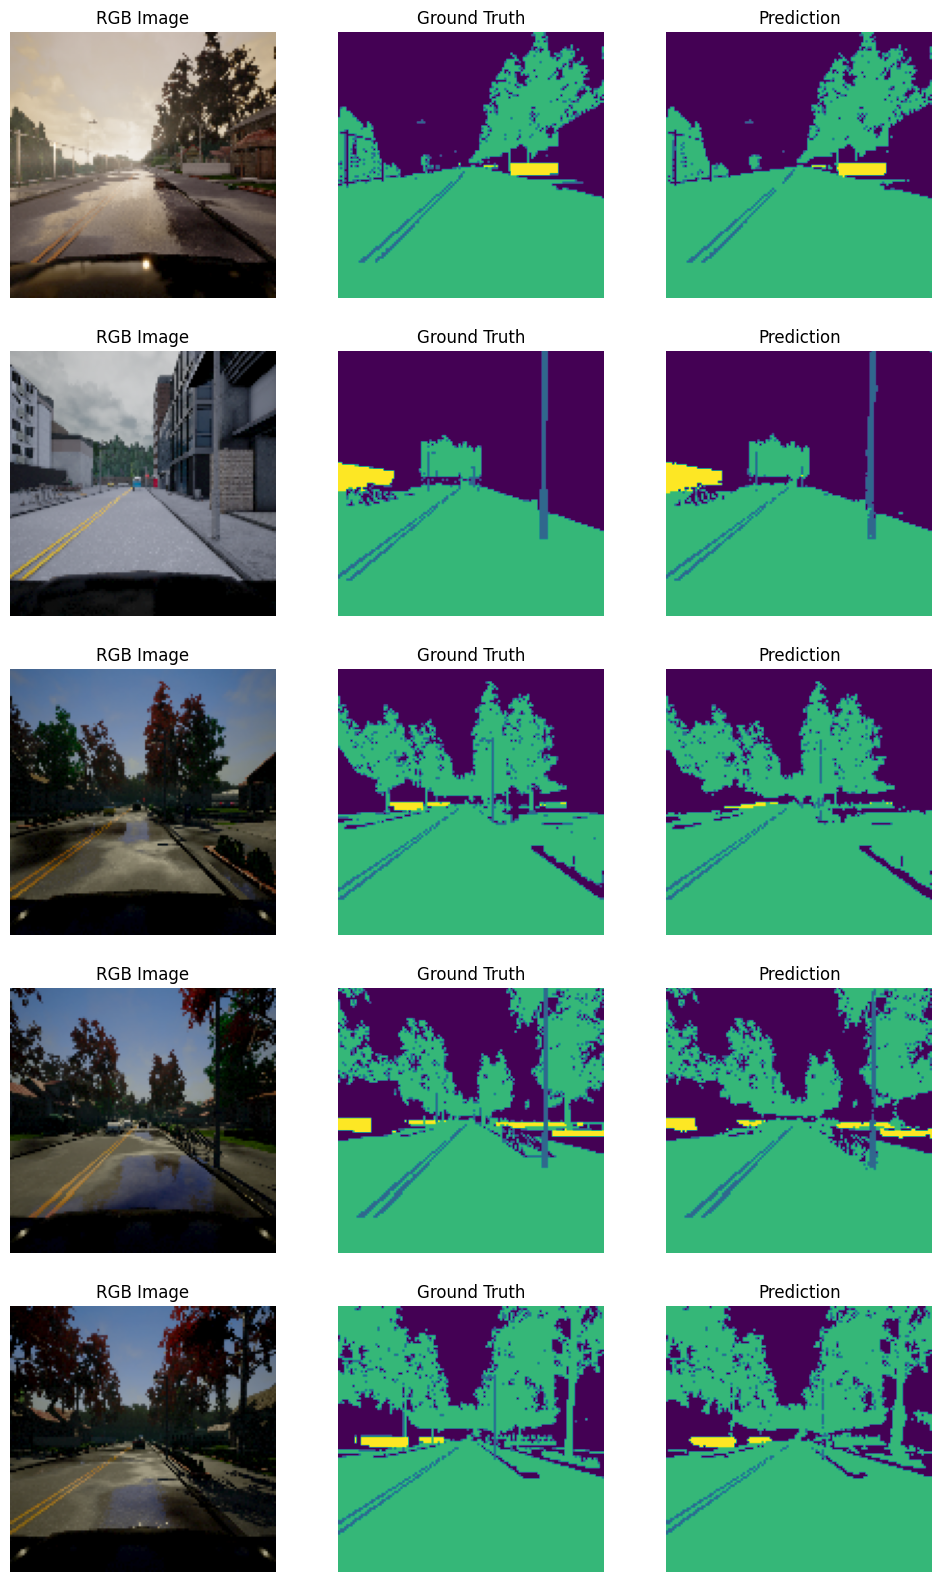

In [31]:
# Visualize Predictions
def visualize_predictions(images, masks, preds, num_samples=3):
    plt.figure(figsize=(12, num_samples * 4))
    for i in range(num_samples):
        plt.subplot(num_samples, 3, 3*i + 1)
        plt.imshow(images[i])
        plt.title("RGB Image")
        plt.axis('off')

        plt.subplot(num_samples, 3, 3*i + 2)
        plt.imshow(masks[i], cmap='viridis')
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(num_samples, 3, 3*i + 3)
        plt.imshow(preds[i], cmap='viridis')
        plt.title("Prediction")
        plt.axis('off')
    plt.show()

# Predict and visualize
predictions = dilated_unet_model.predict(X_test).argmax(axis=-1)
visualize_predictions(X_test, y_test, predictions, num_samples=5)


In [32]:
dilated_unet_model.save("dilated_unet_model.h5")